In [ ]:
#@title Check runtime for nvidia graphics card
!nvidia-smi -L

In [2]:
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [3]:
#@title NN parameters
IMG_SIZE = 224 #@param {type:"integer"}
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

SPLIT_WEIGHTS = (8, 1, 1)
BATCH_SIZE = 64 #@param {type:"integer"}
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
#@title (For google colab) Download and unpack dataset

# Mount google drive
from google.colab import drive
drive_path = '/content/drive/MyDrive' #@param {type:"string"}
drive.mount('/content/drive')

# Download and unpack dataset
!mkdir dataset
!unzip drive/MyDrive/image_photo_classifier/dataset/photos.zip -d dataset
!unzip drive/MyDrive/image_photo_classifier/dataset/images.zip -d dataset

clear_output()

In [4]:
#@title Load images data

def get_files_in_folder(path: str) -> list:
    return list(glob.glob(f'{path}/*.jpg'))

def read_image(image_path) -> list:
    target_size = (IMG_SIZE, IMG_SIZE)
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode = "rgb", target_size=target_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    return x

# Create dataset
x_photos = [read_image(x) for x in get_files_in_folder('dataset/photos')]
x_images = [read_image(x) for x in get_files_in_folder('dataset/images')[:2000]]

x_train = []
y_train = []

[(x_train.append(f), y_train.append(0)) for f in x_photos] # photo as photo
[(x_train.append(f), y_train.append(1)) for f in x_images] # images as image

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

print('Done')
print(f'Image shapes: {x_train.shape}')

Done
Image shapes: (3488, 224, 224, 3)


In [5]:
#@title Create TensorFlow compatible dataset and free memory

train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.20)
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=0.50)

train_y = train_y.astype(np.float32)
test_y = test_y.astype(np.float32)

#free memory
del x_train, y_train

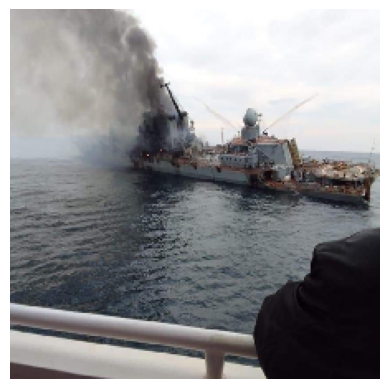

In [6]:
#@title Show random image from dataset

index = np.random.choice(len(test_x))
img = test_x[index]
img = img.reshape(IMG_SHAPE)

plt.imshow((img.reshape(IMG_SHAPE)).astype(np.uint8), vmin=0, vmax=255)
plt.axis("off")
plt.show()

In [ ]:
#@title MobileNetV2 model

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

In [ ]:
#@title Train model
epochs = 70 #@param {type:"slider", min:1, max:100, step:1}
%time score = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(test_x, test_y))

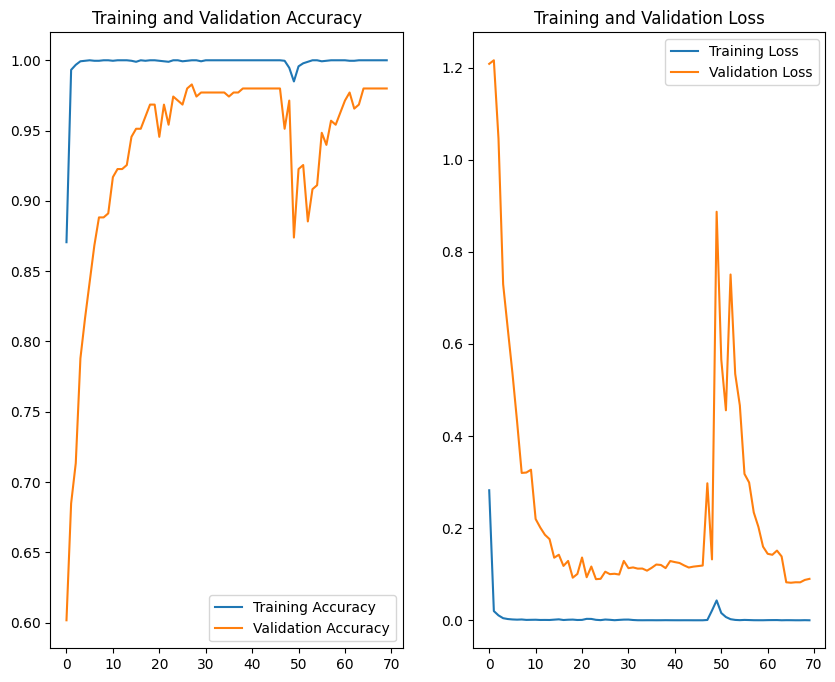

In [40]:
#@title Train history

acc = score.history['accuracy']
val_acc = score.history['val_accuracy']

loss = score.history['loss']
val_loss = score.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

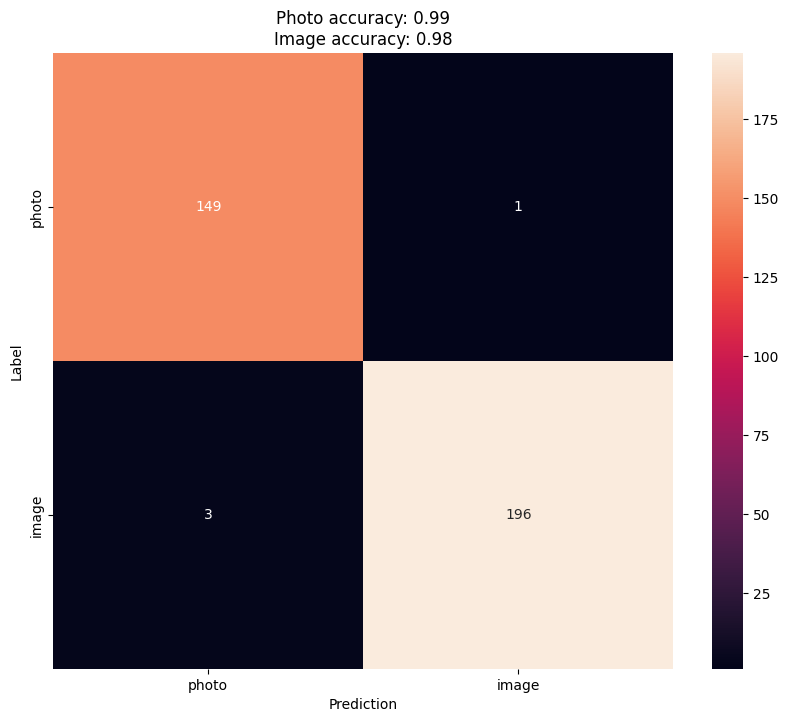

In [42]:
#@title Confusion matrix
import seaborn as sns

label_names = ['photo', 'image']

def predict_class_label_number(dataset):
  results = []

  for img in dataset:
      img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
      result = model.predict(img, verbose=0)
      res = min(max(result[0][0], 0), 1)
      results.append(res)

  return results

def show_confusion_matrix(cm, labels, title):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.title(title)
  plt.show()

confusion_mtx = tf.math.confusion_matrix(val_y, predict_class_label_number(val_x), num_classes=len(label_names))

image_true_positive = confusion_mtx.numpy()[0][0]
photo_false_negative = confusion_mtx.numpy()[0][1]
photo_true_positive = confusion_mtx.numpy()[1][1]
image_false_positive = confusion_mtx.numpy()[1][0]

photo_total = photo_false_negative + photo_true_positive
image_total = image_true_positive + image_false_positive

title = f'Photo accuracy: {photo_true_positive / photo_total:.2f}\nImage accuracy: {image_true_positive / image_total:.2f}'

show_confusion_matrix(confusion_mtx, label_names, title)

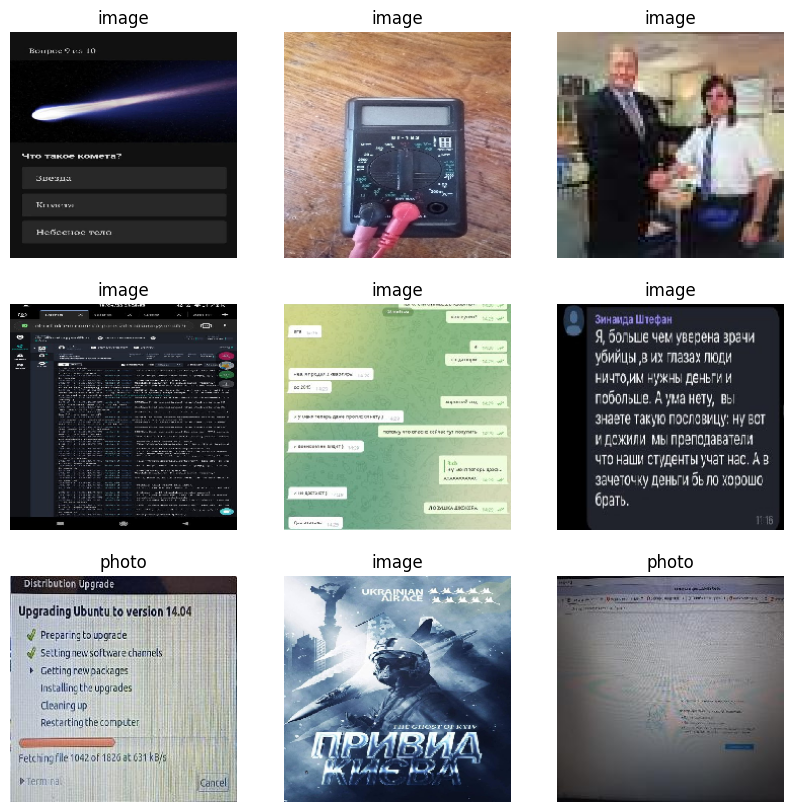

In [34]:
#@title Make 9 predictions
indexes = np.random.choice(len(test_x), 29)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = test_x[indexes[i]]
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    result = model.predict(img, verbose=0)
    class_label = "image" if result[0][0] > 0 else "photo"
    str_result = f"{class_label}"
    plt.title(str_result)
    plt.axis("off")
    plt.imshow((img.reshape(IMG_SIZE, IMG_SIZE, 3)).astype(np.uint8))
    
plt.show()

In [ ]:
#@title Convert model

model_name = 'mobilenetV2_image_photo_classificator_v3' #@param {type:"string"}

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Comment this line if you run this notebook in google colab!
drive_path = 'image-photo-classifier/model'
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

save_model = True #@param {type:"boolean"}
if save_model:
    print(f'Saving model to {drive_path}/{model_name}.h5')
    model.save(f'{drive_path}/{model_name}.h5')
    print(f'Saved')


save_tfjs_model = True  #@param {type:"boolean"}
if save_tfjs_model:
    !pip install tensorflowjs
    import tensorflowjs as tfjs
    clear_output()
    tfjs.converters.save_keras_model(model, f"{drive_path}/{model_name}")


save_tflite_model = True #@param {type:"boolean"}
if save_tflite_model:
    print(f'Saving model to {drive_path}/{model_name}.tflite')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(f'{drive_path}/{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
        print(f'Saved')


save_tflite_quant_model = True #@param {type:"boolean"}
if save_tflite_quant_model:
    print(f'Saving quant model to {drive_path}/{model_name}_quant.tflite')
    # A generator that provides a representative dataset
    def representative_data_gen():
        for image in test_x[:100]:
          im = image.reshape(1, IMG_SHAPE[0], IMG_SHAPE[0], IMG_SHAPE[2]).astype(np.float32)
          yield [im]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # This enables quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # This sets the representative dataset for quantization
    converter.representative_dataset = representative_data_gen
    # This ensures that if any ops can't be quantized, the converter throws an error
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
    converter.target_spec.supported_types = [tf.int8]
    # These set the input and output tensors to uint8 (added in r2.3)
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    tflite_model = converter.convert()


    with open(f'{drive_path}/{model_name}_quant.tflite', 'wb') as f:
        f.write(tflite_model)
        print(f'Saved')